In [ ]:
"""Trains the AlphaZero agent on a single machine for the game of Go."""
import os

# This forces OpenMP to use 1 single thread, which is needed to
# prevent contention between multiple process.
os.environ['OMP_NUM_THREADS'] = '1'
# Tell numpy to only use one core.
os.environ['MKL_NUM_THREADS'] = '1'


import multiprocessing as mp
import sys
from absl import flags

import numpy as np
import torch
from torch.optim.lr_scheduler import MultiStepLR

FLAGS = flags.FLAGS

flags.DEFINE_integer('board_size', 9, 'Board size for Go.')
flags.DEFINE_float('komi', 7.5, 'Komi rule for Go.')
flags.DEFINE_integer(
    'num_stack',
    8,
    'Stack N previous states, the state is an image of N x 2 + 1 binary planes.',
)
flags.DEFINE_integer('num_res_blocks', 10, 'Number of residual blocks in the neural network.')
flags.DEFINE_integer('num_filters_resnet', 128, 'Number of filters for the conv2d layers in the neural network.')
flags.DEFINE_integer(
    'num_fc_units',
    128,
    'Number of hidden units in the linear layer of the neural network.',
)

flags.DEFINE_integer(
    'num_simulations',
    200,
    'Number of simulations per MCTS search, this applies to both self-play and evaluation processes.',
)

flags.DEFINE_integer(
    'num_parallel',
    8,
    'Number of leaves to collect before using the neural network to evaluate the positions during MCTS search,'
    '1 means no parallel search.',
)
flags.DEFINE_float(
    'c_puct_base',
    19652,
    'Exploration constants balancing priors vs. search values. Original paper use 19652',
)
flags.DEFINE_float(
    'c_puct_init',
    1.25,
    'Exploration constants balancing priors vs. search values. Original paper use 1.25',
)

flags.DEFINE_float(
    'default_rating',
    1500,
    'Default elo rating, change to the rating (for black) from last checkpoint when resume training.',
)
flags.DEFINE_string(
    'logs_dir',
    './logs/go/9x9/alphago_series',
    'Path to save statistics for self-play, training, and evaluation.',
)
flags.DEFINE_string('log_level', 'INFO', '')
flags.DEFINE_integer('seed', 1, 'Seed the runtime.')
# Initialize flags
FLAGS(sys.argv, known_only = True)

os.environ['BOARD_SIZE'] = str(FLAGS.board_size)

In [ ]:
from alpha_zero.envs.go import GoEnv
from alpha_zero.core.pipeline import (
    set_seed,
    maybe_create_dir,
)
from alpha_zero.core.multi_game import run_pair_game_series
from alpha_zero.core.quantum_net import QuantumAlphaZeroNet
from alpha_zero.core.network import AlphaZeroNet
from alpha_zero.utils.util import extract_args_from_flags_dict, create_logger

Plink failed to import tkinter.


In [ ]:
agent_configs = [
    {
        'name': 'Agent_1',
        'num_filters': 128,
        'max_depth': 3,
        'branching_width': 3,
        'beam_width': 1,
        'num_fc_units':128,
        'num_search':3,
        'load_chkpt' : './checkpoints/go/9x9/quantum/d_3s_3br_3f_128be_1/training_steps_12500.ckpt'
    },

    {
        'name': 'Agent_2',
        'num_filters': 84,
        'max_depth': 2,
        'branching_width': 3,
        'beam_width': 1,
        'num_fc_units':128,
        'num_search':5,
        'load_chkpt' : './checkpoints/go/9x9/quantum/d_2s_5br_3f_84be_1/training_steps_12500.ckpt'
    },

]


In [4]:
def env_builder():
        return GoEnv(komi=FLAGS.komi, num_stack=FLAGS.num_stack)
eval_env = env_builder()

input_shape = eval_env.observation_space.shape
num_actions = eval_env.action_space.n

# Initialize agents
Agents = []
for config in agent_configs:
    agent = QuantumAlphaZeroNet(
        input_shape,
        num_actions,
        config['num_filters'],
        config['max_depth'],
        config['branching_width'],
        config['beam_width'],
        config['num_fc_units'],
        config['num_search'],
    )
    Agents.append(agent)

resnet_agent = AlphaZeroNet(
            input_shape,
            num_actions,
            FLAGS.num_res_blocks,
            FLAGS.num_filters_resnet,
            FLAGS.num_fc_units,
        )
resnet_chkpt = './checkpoints/go/9x9/resnets/network/training_steps_5500.ckpt'

In [ ]:
# Initialize agents with metadata
agents = {
    "ResNet": {
        "network": resnet_agent,
        "elo_rating": 1200,  # Initial Elo rating
        "checkpoint": resnet_chkpt,
    }
}

# Add QuantumAlphaZeroNet agents
for config, agent in zip(agent_configs, Agents):
    agents[config["name"]] = {
        "network": agent,
        "elo_rating": 1200,  # Initial Elo rating
        "checkpoint": config["load_chkpt"],
    }


In [ ]:
import matplotlib.pyplot as plt
import os

def visualize_all_elo_ratings(agents: dict, logs_dir: str) -> None:
    """
    Create a bar chart of Elo ratings for all agents.

    Args:
        agents (dict): Dictionary containing agent information, including Elo ratings.
        logs_dir (str): Directory to save the Elo ratings chart.

    Returns:
        None
    """
    # Extract agent names and Elo ratings
    agent_names = list(agents.keys())
    elo_ratings = [agent["elo_rating"] for agent in agents.values()]

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(agent_names, elo_ratings, color="skyblue")
    plt.xlabel("Agents")
    plt.ylabel("Elo Rating")
    plt.title("Elo Ratings for All Agents")
    plt.xticks(rotation=45, ha="right")  # Rotate labels for better readability
    plt.tight_layout()

    # Save and display the plot
    output_path = os.path.join(logs_dir, "elo_ratings_all_agents.png")
    os.makedirs(logs_dir, exist_ok=True)
    plt.savefig(output_path)
    plt.show()

    print(f"Elo ratings chart saved at: {output_path}")


In [5]:
set_seed(FLAGS.seed)

logger = create_logger(FLAGS.log_level)

logger.info(extract_args_from_flags_dict(FLAGS.flag_values_dict()))


INFO 2024-11-28 19:17:51 3364720299.py:5] {'board_size': 9, 'komi': 7.5, 'num_stack': 8, 'num_res_blocks': 10, 'num_filters_resnet': 128, 'num_fc_units': 128, 'num_simulations': 200, 'num_parallel': 8, 'c_puct_base': 19652.0, 'c_puct_init': 1.25, 'default_rating': 0.0, 'logs_dir': './logs/go/9x9/alphago_series', 'log_level': 'INFO', 'seed': 1}


INFO 2024-11-28 19:28:00 multi_game.py:215] network 1 model loaded from checkpoint: ./checkpoints/go/9x9/resnets/network/training_steps_5500.ckpt
INFO 2024-11-28 19:28:00 multi_game.py:221] network 2 model loaded from checkpoint: ./checkpoints/go/9x9/quantum/d_3s_3br_3f_128be_1/training_steps_12500.ckpt
INFO 2024-11-28 19:28:00 multi_game.py:254] Playing game 1/2


Go (9x9)
Black: X, White: O

Game over: No, Result: W+7.5
Steps: 0, Current player: X

X captures: 0, O captures: 0 

     A  B  C  D  E  F  G  H  J  
   +---------------------------+
9  | .  .  .  .  .  .  .  .  . | 9 
8  | .  .  .  .  .  .  .  .  . | 8 
7  | .  .  .  .  .  .  .  .  . | 7 
6  | .  .  .  .  .  .  .  .  . | 6 
5  | .  .  .  .  .  .  .  .  . | 5 
4  | .  .  .  .  .  .  .  .  . | 4 
3  | .  .  .  .  .  .  .  .  . | 3 
2  | .  .  .  .  .  .  .  .  . | 2 
1  | .  .  .  .  .  .  .  .  . | 1 
   +---------------------------+
     A  B  C  D  E  F  G  H  J  

Go (9x9)
Black: X, White: O

Game over: No, Result: B+73.5
Steps: 1, Current player: O

X captures: 0, O captures: 0 

     A  B  C  D  E  F  G  H  J  
   +---------------------------+
9  | .  .  .  .  .  .  .  .  . | 9 
8  | .  .  .  .  .  .  .  .  . | 8 
7  | .  .  .  .  .  .  .  .  . | 7 
6  | .  . (X) .  .  .  .  .  . | 6 
5  | .  .  .  .  .  .  .  .  . | 5 
4  | .  .  .  .  .  .  .  .  . | 4 
3  | .  .  .  .  .  .  .

INFO 2024-11-28 19:28:36 multi_game.py:277] Game 1 result: White wins - resnet: -15.263693206478006, Agent_1: 16.0
INFO 2024-11-28 19:28:36 multi_game.py:254] Playing game 2/2


Go (9x9)
Black: X, White: O

Game over: No, Result: W+6.5
Steps: 107, Current player: O

X captures: 16, O captures: 16 

     A  B  C  D  E  F  G  H  J  
   +---------------------------+
9  | X  X  X  X  X (X) X  X  . | 9 
8  | X  X  .  X  X  X  X  X  X | 8 
7  | X  X  X  X  X  X  X  O  X | 7 
6  | X  X  X  O  X  O  O  O  O | 6 
5  | .  X  X  O  O  .  O  O  O | 5 
4  | X  X  X  O  .  O  .  O  . | 4 
3  | X  X  O  .  O  .  O  .  O | 3 
2  | X  X  O  O  O  O  .  O  . | 2 
1  | X  O  O  O  O  .  O  .  O | 1 
   +---------------------------+
     A  B  C  D  E  F  G  H  J  

Go (9x9)
Black: X, White: O

Game over: No, Result: W+6.5
Steps: 108, Current player: X

X captures: 16, O captures: 16 

     A  B  C  D  E  F  G  H  J  
   +---------------------------+
9  | X  X  X  X  X  X  X  X  . | 9 
8  | X  X  .  X  X  X  X  X  X | 8 
7  | X  X  X  X  X  X  X  O  X | 7 
6  | X  X  X  O  X  O  O  O  O | 6 
5  | .  X  X  O  O  .  O  O  O | 5 
4  | X  X  X  O  .  O  .  O  . | 4 
3  | X  X  O  .  

INFO 2024-11-28 19:29:12 multi_game.py:277] Game 2 result: White wins - resnet: -29.165398997630334, Agent_1: 30.564127121723708
INFO 2024-11-28 19:29:12 multi_game.py:284] Game result: White wins
INFO 2024-11-28 19:29:12 multi_game.py:285] Elo rating : resnet: -29.165398997630334, Agent_1: 30.564127121723708
INFO 2024-11-28 19:29:12 multi_game.py:286] Game length: 109 moves


Go (9x9)
Black: X, White: O

Game over: No, Result: W+6.5
Steps: 107, Current player: O

X captures: 16, O captures: 16 

     A  B  C  D  E  F  G  H  J  
   +---------------------------+
9  | X  X  X  X  X (X) X  X  . | 9 
8  | X  X  .  X  X  X  X  X  X | 8 
7  | X  X  X  X  X  X  X  O  X | 7 
6  | X  X  X  O  X  O  O  O  O | 6 
5  | .  X  X  O  O  .  O  O  O | 5 
4  | X  X  X  O  .  O  .  O  . | 4 
3  | X  X  O  .  O  .  O  .  O | 3 
2  | X  X  O  O  O  O  .  O  . | 2 
1  | X  O  O  O  O  .  O  .  O | 1 
   +---------------------------+
     A  B  C  D  E  F  G  H  J  

Go (9x9)
Black: X, White: O

Game over: No, Result: W+6.5
Steps: 108, Current player: X

X captures: 16, O captures: 16 

     A  B  C  D  E  F  G  H  J  
   +---------------------------+
9  | X  X  X  X  X  X  X  X  . | 9 
8  | X  X  .  X  X  X  X  X  X | 8 
7  | X  X  X  X  X  X  X  O  X | 7 
6  | X  X  X  O  X  O  O  O  O | 6 
5  | .  X  X  O  O  .  O  O  O | 5 
4  | X  X  X  O  .  O  .  O  . | 4 
3  | X  X  O  .  

FileNotFoundError: [Errno 2] No such file or directory: '/home/banashree/neural-search/logs/go/9x9/alphago_series/elo_ratings_comparison.png'

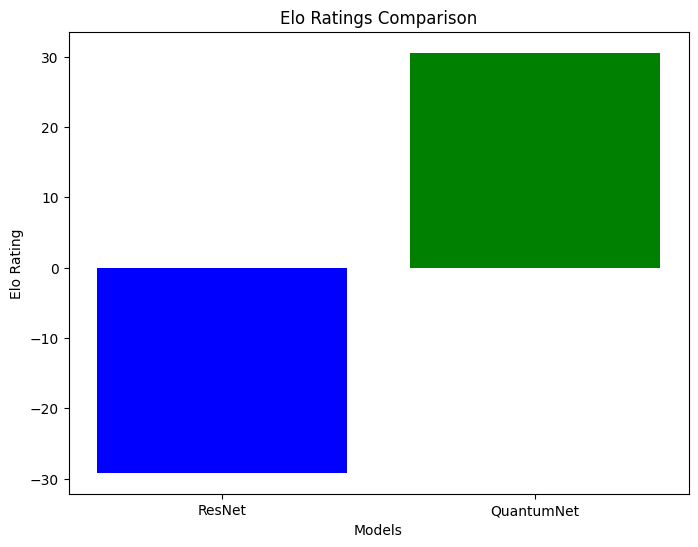

In [ ]:
if torch.cuda.is_available():
    learner_device = torch.device('cuda')

run_pair_game_series(
    seed = FLAGS.seed,
    network_1 = resnet_agent,
    network_2 = Agents[0],
    name_1 = 'resnet',
    name_2 = agent_configs[0]['name'],
    device = learner_device,
    env = eval_env,
    num_games = 2,
    num_simulations = FLAGS.num_simulations,
    num_parallel = FLAGS.num_parallel,
    # num_games = 6,
    c_puct_base = FLAGS.c_puct_base,
    c_puct_init = FLAGS.c_puct_init,
    default_rating = FLAGS.default_rating,
    logs_dir = FLAGS.logs_dir,
    load_ckpt_1 = resnet_chkpt,
    load_ckpt_2 = agent_configs[0]['load_chkpt'],
    log_level = FLAGS.log_level,
)

In [8]:
list_1 = [1,2,3,4]
from itertools import combinations

In [9]:
for agent_1_name, agent_2_name in combinations(list_1, 2):
        print(f"Playing 10 games between {agent_1_name} and {agent_2_name}")

Playing 10 games between 1 and 2
Playing 10 games between 1 and 3
Playing 10 games between 1 and 4
Playing 10 games between 2 and 3
Playing 10 games between 2 and 4
Playing 10 games between 3 and 4


In [ ]:
# def hook_fn(module, input, output):
#     print(f"Input shape: {module}, {input[0].shape}")  # input is a tuple; get the shape of the first element
#     print(f"Output shape:{module}, {output.shape}")

In [ ]:
# Register the hook on the first layer of conv_block1
# hook_handle = network.conv_block.register_forward_hook(hook_fn)